In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
from importlib import reload
from src import create_fake_patients, whole_model_demographics_gradcam, graph_plot, plot_feature_value, ga, gc

In [2]:
second_TGCNN_layer = True
demo = True


stride = 1
filter_size = 4
num_filters = 16
years_in_advance = '5'
hip_or_knee='hip'
max_timesteps=100
include_drugs = True
if include_drugs:
    max_event_codes = 518
else:
    max_event_codes = 512

# fake mapping dataframe for the ReadCodes and the corresponding descriptions
read_code_map_df = pd.read_csv('fake_read_code_descriptions.csv')

model = whole_model_demographics_gradcam.TGCNN_Model(num_filters=num_filters, num_nodes=max_event_codes, num_time_steps=max_timesteps, 
                            filter_size=filter_size, variable_gamma=True, 
                            exponential_scaling=True, dropout_rate=0.7, lstm_units=64,
                            fcl1_units=128, LSTM_ablation=False, stride=stride, activation_type='LeakyReLU', 
                            no_timestamp=False, second_TGCNN_layer=second_TGCNN_layer, num_labels=1)
model.load_weights('hip_1999_to_one_year_advance_model1_CNN_layer')

# Load in the filters from the model
with open('hip_1999_to_one_year_advance_model1_filter.npy', 'rb') as f:
    filters = np.load(f)


normalised gamma [[0.01399556]]
normalised gamma [[-0.0089203]]


### Get the violin plots to show maximum activation difference

In [20]:
num_patients = 10

pat_df = create_fake_patients.create_fake_patient_df(num_patients=num_patients, 
                                                     max_events=max_timesteps-1, 
                                                     max_nodes=max_event_codes)

replacement_true_lst, max_w_filt_lst, filt_nums = ga.get_act_metric_per_feat(model, num_filters, num_patients, 
                                                                             pat_df, max_event_codes, hip_or_knee,
                                                                             'max')


In [24]:
reload(plot_feature_value)

<module 'src.plot_feature_value' from 'c:\\Users\\alexg\\OneDrive - University of Leeds\\explainable_TGCNN\\src\\plot_feature_value.py'>

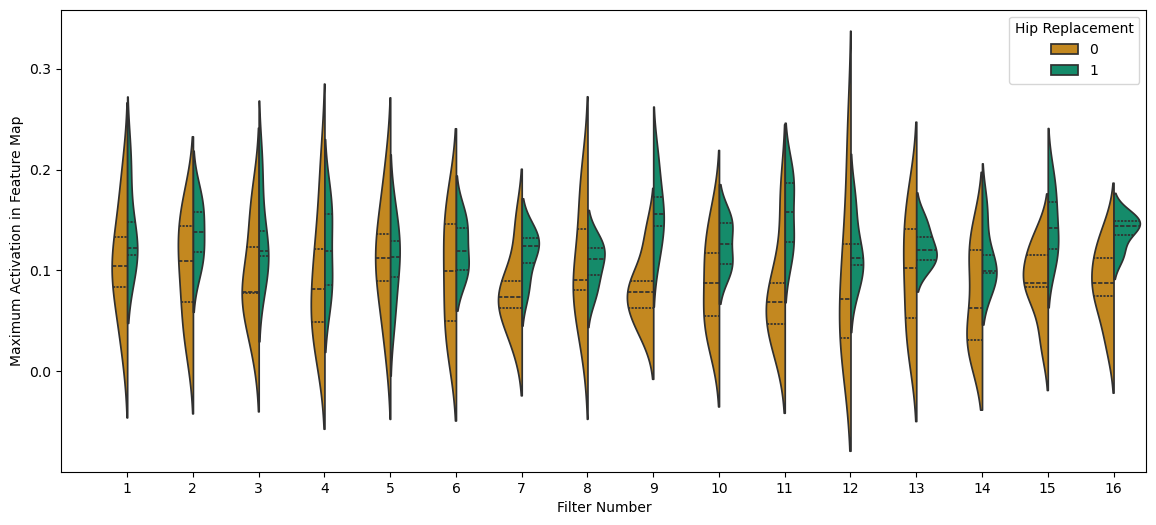

In [25]:
plot_feature_value.violin_plots(filt_nums, max_w_filt_lst, replacement_true_lst)

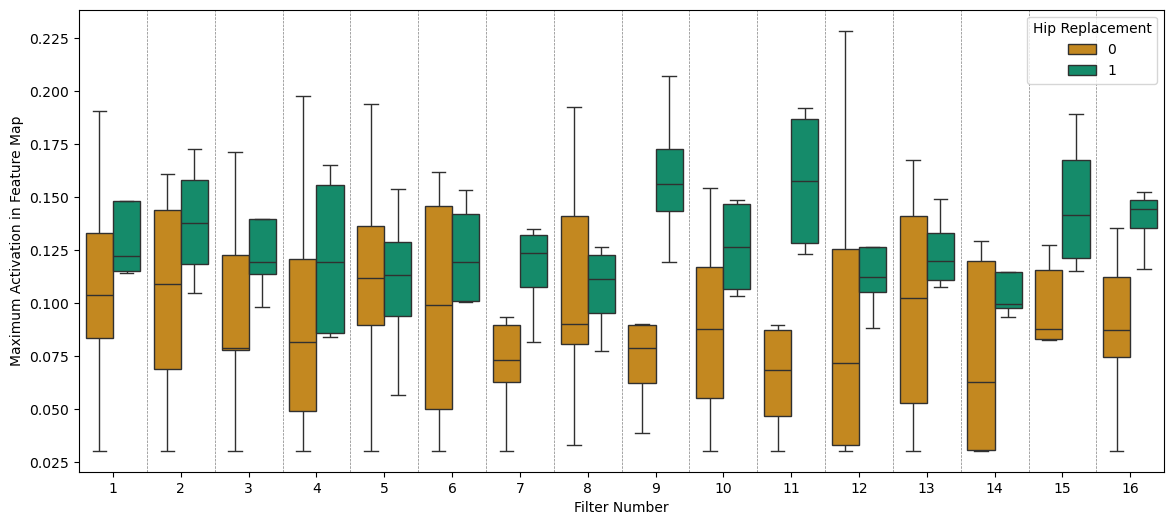

In [26]:
plot_feature_value.max_act_box_plots(filt_nums, max_w_filt_lst, replacement_true_lst)

### Calculate the strongest difference in activation between the patient and control participants

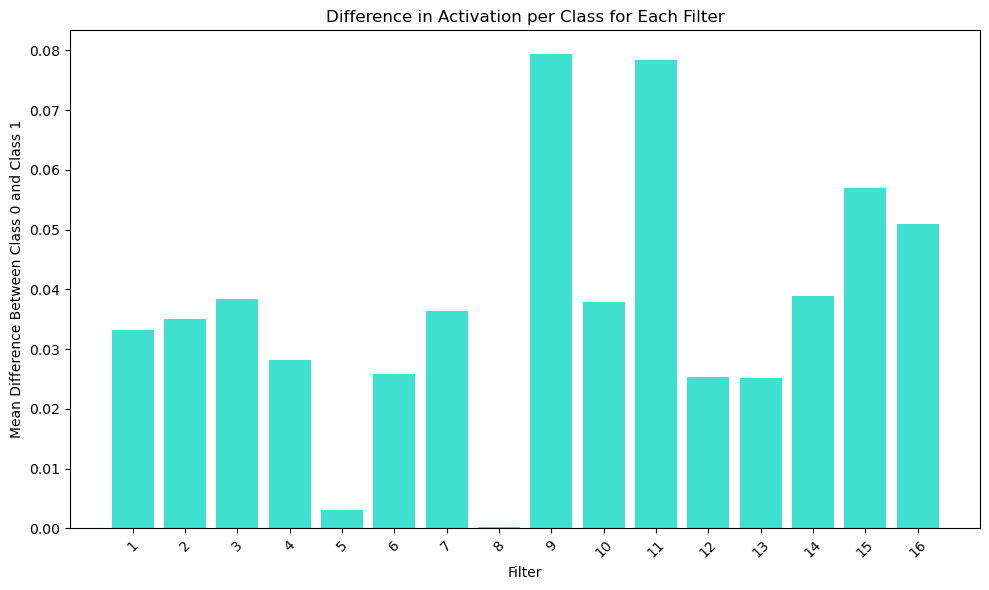

In [27]:
mean_activation_df = ga.act_diff(replacement_true_lst, max_w_filt_lst, filt_nums)

In [7]:
# Graph with edges from one filter

In [8]:
# Graph with edges from an average of all filters?
# Or remove feature maps with lower activations.

### Activation mapping - timesteps

In [38]:
# Generate individual data for the model
input_3d, input_4d, demo_tensor, outcome, outcome_bin = create_fake_patients.return_fake_pat(2, 99, 518, 'hip', 0)

dense_tensor = tf.sparse.to_dense(input_3d)
dense_tensor= tf.transpose(dense_tensor, perm=[2, 1, 0])
dense_tensor = np.flip(dense_tensor, axis=0)
logits = model(input_4d, demo_tensor, training=False)



### Feature map plots

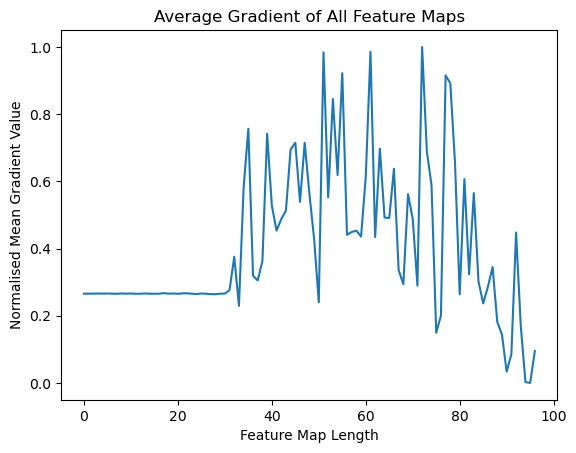

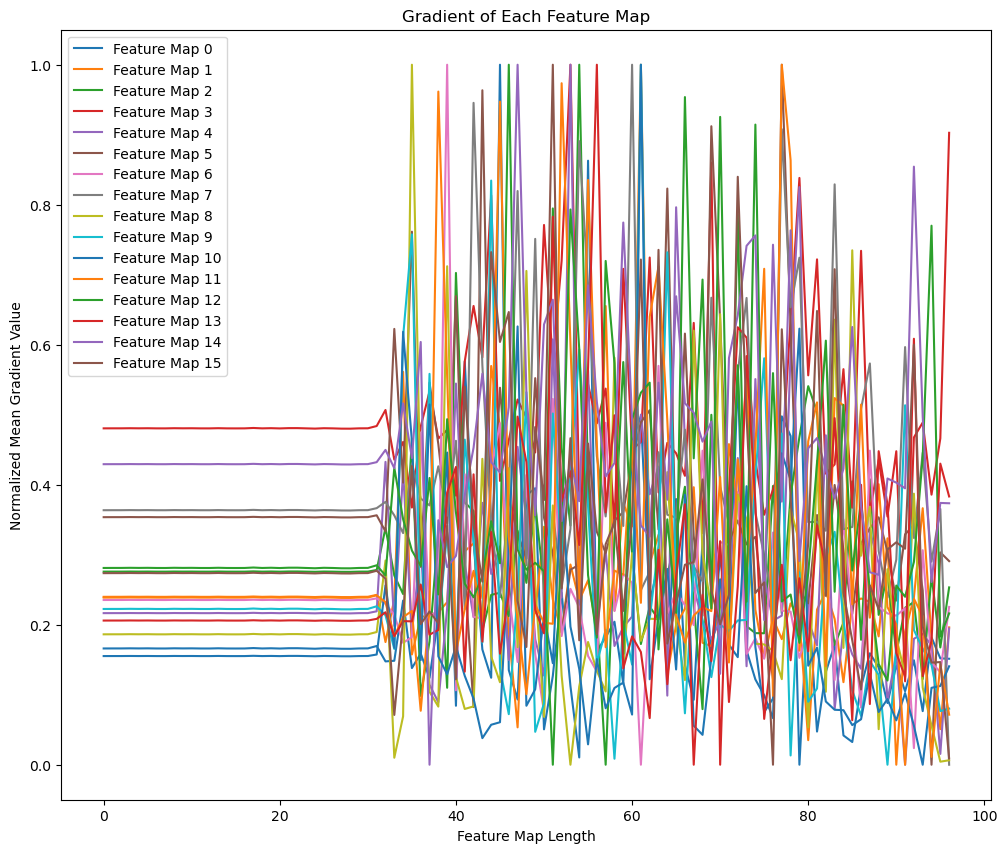

In [39]:
# PLOT THE FEATURE MAPS
norm_features = plot_feature_value.plot_ave_grad_all_f_maps(model.f_map_branch1)

plot_feature_value.plot_indv_grad_f_maps(model.f_map_branch1)

### Graph plots

In [45]:
reload(ga)

<module 'src.ga' from 'c:\\Users\\alexg\\OneDrive - University of Leeds\\explainable_TGCNN\\src\\ga.py'>

In [49]:
# Get the entire patient's history in a DataFrame
edges_df = graph_plot.create_edges_df_gc(dense_tensor)

# Get the node positions for the graph
pos_df = graph_plot.create_position_df_gc(edges_df)
pos_list = graph_plot.generate_pos_sequence(pos_df['max_codes_per_visit'].max())
pos_df = graph_plot.map_y_coord_to_node(pos_df, pos_list)


#  get the feature maps

f_maps = tf.squeeze(model.f_map_branch1)

# INSTEAD OF THIS METRIC CODE - COULD JUST TAKE ONE FILTER

metric = 'mean'
# get the average or median across the feature maps
if metric == 'mean':
    comb_f_maps = tf.reduce_sum(f_maps, axis=0)
elif metric == 'median': # if the violin plots are not normally distributed then take the median
    x_sorted = tf.sort(f_maps, axis=2)
    n = x_sorted.shape[2]

    # Calculate the median index
    middle = n // 2

    # Compute the median along the specified axis
    # If the size of the axis is odd, take the middle element
    # If even, average the two middle elements
    comb_f_maps = tf.cond(
        tf.equal(n % 2, 1),
        lambda: tf.gather(x_sorted, middle, axis=2),
        lambda: tf.reduce_mean(tf.gather(x_sorted, [middle - 1, middle], axis=2), axis=2)
    )

# map the timesteps to their relevant features

timestep_ave_w_df = gc.calc_timestep_weights(1, filter_size, np.array(comb_f_maps), max_timesteps)


# map the timestep values to colour the edges of the graph
read_code_pos_df = gc.map_read_code_labels(pos_df, read_code_map_df, timestep_ave_w_df)

edge_pos_df = gc.create_edge_pos_df(edges_df, pos_df)

gc.plot_gradcam_plotly(edge_pos_df, pos_df, read_code_pos_df, years_in_advance, logits, outcome, 'all_filters_time_act')
